# ML-QuIC Demonstration Notebook

### Metrics Quick Reference
Accuracy = % correct
Precision = % identified positive which actually were
Recall = % of positive samples identified

## Universal Import of Data and Packages

In [1]:
### Import Packages
import importlib as imp
import ML_QuIC as ML_QuIC
imp.reload(ML_QuIC)
import copy
import numpy as np
import tensorflow as tf

In [2]:
### Import Data and Create Objects to Analyze
DATA_DIR = '../Data/BigAnalysis'
RANDOM_SEED = 7

# Load data
ml_quic = ML_QuIC.ML_QuIC()
ml_quic.import_dataset(data_dir=DATA_DIR);

Loading Data from ../Data/BigAnalysis


## Supervised - Raw Data

### Multilayer Perceptron

In [3]:
### MLP
from Models import MLP as MLP
imp.reload(MLP)

# Add MLP to list of supervised models
ml_quic.add_model(MLP.MLP(NDIM = ml_quic.get_num_timesteps_raw()), model_name = 'MLP', data_type = 'raw', tag='Supervised')

### Support Vector Machine

In [4]:
### SVM
from Models import SVM
imp.reload(SVM)

# Add SVM to list of supervised models
ml_quic.add_model(SVM.SVM(), model_name = 'SVM', data_type = 'raw', tag = 'Supervised')

### Train and Compare Supervised Models

In [5]:
### Train Supervised Models
ml_quic.separate_train_test(tags=['Supervised'], train_type=0)
ml_quic.train_models(tags = ['Supervised'])

29/29 [==============================] - 0s 1ms/step
MLP:
              precision    recall  f1-score   support

         neg       1.00      0.97      0.98       806
         pos       0.81      1.00      0.90       120

    accuracy                           0.97       926
   macro avg       0.91      0.98      0.94       926
weighted avg       0.98      0.97      0.97       926

SVM:
              precision    recall  f1-score   support

         neg       0.99      0.97      0.98       806
         pos       0.81      0.96      0.88       120

    accuracy                           0.97       926
   macro avg       0.90      0.96      0.93       926
weighted avg       0.97      0.97      0.97       926

-------- Results on False Positives for MLP --------
29/29 [==============================] - 0s 1ms/step
Accuracy on False Positives: 0.06666666666666667
False Positives Account for 100.00% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 33

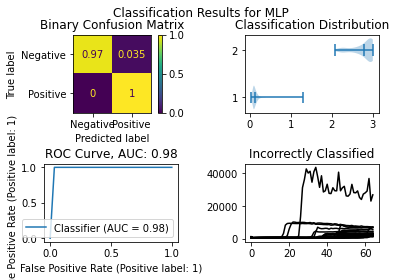

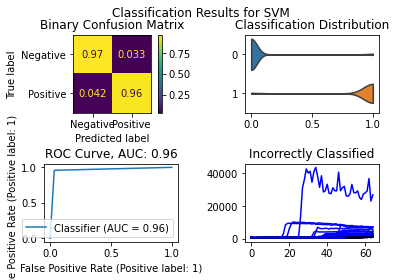

In [6]:
### Get Supervised Scores and Plots
ml_quic.get_model_scores(tags = ['Supervised'])
ml_quic.evaluate_fp_performance(tags=['Supervised'])
ml_quic.get_model_plots(tags=['Supervised'])

## Unsupervised - Analysis

### Create New Object

In [7]:
raw_ml_quic = copy.copy(ml_quic)
ml_quic = ML_QuIC.ML_QuIC()
ml_quic.import_dataset(data_dir=DATA_DIR);

Loading Data from ../Data/BigAnalysis


### Add KMeans Model

In [8]:
### Add KMeans to the list of models to test
from Models import KMeansModel
ml_quic.add_model(KMeansModel.KMeansModel(n_clusters = 3), model_name='KMeans', data_type='analysis', tag='Unsupervised')
ml_quic.separate_train_test(model_names=['KMeans'], train_type=3)

[{'KMeans': array([ 329, 5703, 3984, ..., 2044,  525, 6721])},
 {'KMeans': array([ 521, 1023, 7627, ..., 7817, 5321, 8939])}]

### Train and Compare Unsupervised Models

KMeans:
              precision    recall  f1-score   support

         neg       0.94      0.99      0.96      7991
         pos       0.87      0.59      0.70      1273

    accuracy                           0.93      9264
   macro avg       0.90      0.79      0.83      9264
weighted avg       0.93      0.93      0.93      9264

-------- Results on False Positives for KMeans --------
Accuracy on False Positives: 0.5830258302583026
False Positives Account for 9.22% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 34.1053982300885
Average RAF: 0.033146525522123896
Average MPR: 8.577633678053097
Average MS: 742.1946902654868
Correctly Classified FP Characteristics:
Average Time to Threshold: 35.58272151898734
Average RAF: 0.03451275073417722
Average MPR: 8.027743369449368
Average MS: 575.868670886076
-------- Positive Characteristics for Reference --------
Time To Threshold:
	Min: 4.5, Average: 24.424414768263944, Max: 48.0
RAF:
	Min: 0.0208333

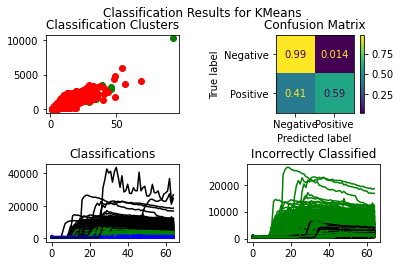

In [9]:
### Get Unsupervised Scores and Plots
ml_quic.train_models(tags=['Unsupervised'])
ml_quic.get_model_scores(tags=['Unsupervised']);
ml_quic.evaluate_fp_performance(tags=['Unsupervised'])
ml_quic.get_model_plots(tags=['Unsupervised'])

### Add Supervised Learning Technique (SVM)

In [10]:
### SVM
from Models import SVM
imp.reload(SVM)

# Add SVM to list of supervised models
ml_quic.add_model(SVM.SVM(), model_name = 'SVM', data_type = 'analysis', tag = 'Supervised')

In [11]:
### MLP
from Models import MLP as MLP
imp.reload(MLP)

# Add MLP to list of supervised models
ml_quic.add_model(MLP.MLP(NDIM = 2), model_name = 'MLP', data_type = 'analysis', tag='Supervised')

In [12]:
### Train Supervised Models
ml_quic.separate_train_test(tags=['Supervised'], train_type=0)
ml_quic.train_models(tags = ['Supervised'])

SVM:
              precision    recall  f1-score   support

         neg       0.99      0.97      0.98       815
         pos       0.80      0.95      0.87       111

    accuracy                           0.97       926
   macro avg       0.90      0.96      0.93       926
weighted avg       0.97      0.97      0.97       926

29/29 [==============================] - 0s 732us/step
MLP:
              precision    recall  f1-score   support

         neg       0.99      0.97      0.98       815
         pos       0.79      0.94      0.86       111

    accuracy                           0.96       926
   macro avg       0.89      0.95      0.92       926
weighted avg       0.97      0.96      0.96       926

-------- Results on False Positives for SVM --------
Accuracy on False Positives: 0.10714285714285714
False Positives Account for 80.65% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 33.57
Average RAF: 0.04306263304
Average MPR: 8.570892

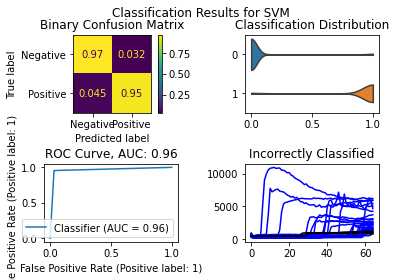

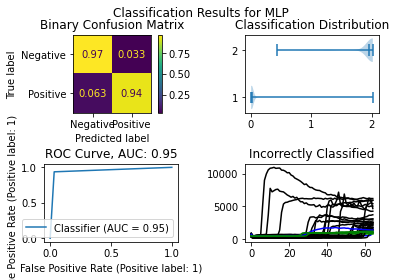

In [13]:
### Get Supervised Scores and Plots
ml_quic.get_model_scores(tags = ['Supervised'])
ml_quic.evaluate_fp_performance(tags=['Supervised'])
ml_quic.get_model_plots(tags=['Supervised'])